# Toy example of hierarchical models in `numpyro`

In which we use the simplest possible toy example of a hierarchical model to get used to the syntax, and then follow that up with an example with hierarchical linear regression.

In [1]:
# Modeling
import numpyro
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS, Predictive

# Diagnostics and Viz
import arviz as az
from numpyro.diagnostics import hpdi
import matplotlib.pyplot as plt

import polars as pl

We'll start by creating some sample data. 

In [2]:
rng_key = random.PRNGKey(42)
key1, key2 = random.split(rng_key, num=2)
global_p = 0.5
store_effects = [0.1, -0.05]

num_obs_per_store = 50
s1 = random.binomial(key1, n=100, p=global_p + store_effects[0], shape=num_obs_per_store)
s2 = random.binomial(key2, n=100, p=global_p + store_effects[1], shape=num_obs_per_store)

sales_obs = jnp.concatenate([s1, s2])
store_indices = jnp.concatenate([jnp.zeros(len(s1), dtype=int), jnp.ones(len(s2), dtype=int)])

data = pl.DataFrame({'store_index': store_indices.tolist(), 'sales':sales_obs.tolist()})
data.head()

store_index,sales
i64,f64
0,62.0
0,49.0
0,64.0
0,61.0
0,68.0


(array([ 4.,  7., 13., 14., 11.,  6., 13., 13., 12.,  7.]),
 array([35.        , 38.29999924, 41.59999847, 44.90000153, 48.20000076,
        51.5       , 54.79999924, 58.09999847, 61.40000153, 64.69999695,
        68.        ]),
 <BarContainer object of 10 artists>)

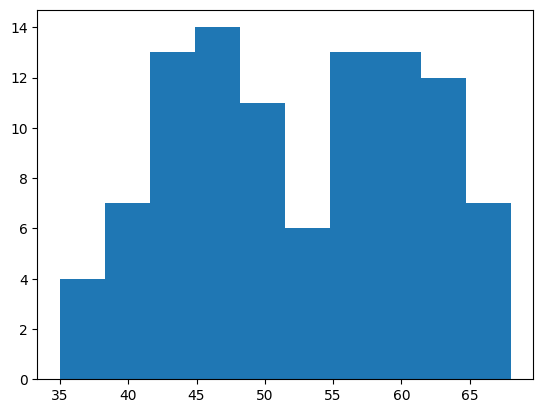

In [3]:
plt.hist(sales_obs)

Let's consider a generic sales model and we would like to infer this unknown probability $p$ of purchases of our product among a subset of 50 customers.

In [4]:
def run_inference(model, num_customers, sales_obs, store_indices=None):
    # Run the inference
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=4)
    mcmc.run(random.PRNGKey(1), num_customers, sales_obs, store_indices)
    return mcmc

In the unpooled case, we set a single prior for the common/shared probability $p$ of success for our stores:

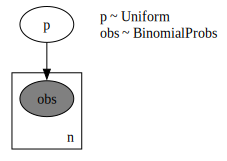

In [5]:
def unpooled(num_customers, sales_obs, store_indices=None):
    p = numpyro.sample("p", dist.Uniform(0, 1))

    with numpyro.plate("n", len(sales_obs)):
        likelihood = numpyro.sample("obs", dist.Binomial(num_customers, p), obs=sales_obs)
        return likelihood
    
numpyro.render_model(unpooled, (100, sales_obs), render_distributions=True)

In [6]:
mcmc = run_inference(unpooled, 100, sales_obs)
az.summary(mcmc)

/var/folders/d5/nxx4jgmn0_5clxt1q54qmb740000gp/T/ipykernel_75550/1099705408.py:4: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=4)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 8709.80it/s, 1 steps of size 1.16e+00. acc. prob=0.90]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.524,0.005,0.515,0.534,0.0,0.0,1566.0,2179.0,1.0


And we see that we get a fairly fast result.

In the partially pooled model, we'll set a hyperprior for the 'global' probability $p$ and there is some 'store effect' that adds or subtracts from this global probability.

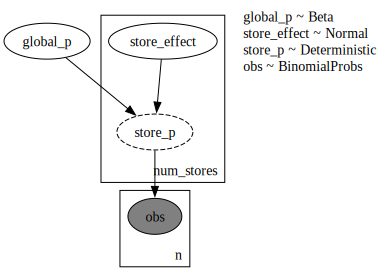

In [7]:
# partial pooled
def partial_pooled(num_customers, sales_obs, store_indices):
    # Need hyperpriors for each probability p
    global_p = numpyro.sample("global_p", dist.Beta(1, 1))

    with numpyro.plate("num_stores", 2):
        store_effects = numpyro.sample("store_effect", dist.Normal(0,0.1))
        p = numpyro.deterministic("store_p", jnp.clip(global_p + store_effects, 0, 1))

    with numpyro.plate("n", len(sales_obs)):
        return numpyro.sample("obs", dist.Binomial(num_customers, p[store_indices]), obs=sales_obs)
    
numpyro.render_model(partial_pooled, (100, sales_obs, store_indices), render_distributions=True)

From a code standpoint, we added 3 major elements:
1. A 'hyperprior' `global_p` set to Beta(1,1) for our global probability
2. Add a plate context for the number of stores and a prior for the store effects
3. Add an index to the store probability where it's used as a parameter `p[store_indices]` in the final `dist.Binomial()` definition. Recall that the `store_indices` is just an array of `[0,1]` but it could be any integer index

In [8]:
mcmc_partial = run_inference(partial_pooled, 100, sales_obs, store_indices)
mcmc_partial.print_summary()

print("true global probability: ", global_p)
print("true store effects: ", store_effects)

/var/folders/d5/nxx4jgmn0_5clxt1q54qmb740000gp/T/ipykernel_75550/1099705408.py:4: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=4)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 3526.17it/s, 1 steps of size 4.23e-02. acc. prob=0.94] 


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
       global_p      0.57      0.10      0.55      0.41      0.73      3.54      1.54
store_effect[0]      0.14      0.13      0.11     -0.04      0.37      2.65      2.03
store_effect[1]     -0.12      0.10     -0.10     -0.28      0.04      3.57      1.53

Number of divergences: 792
true global probability:  0.5
true store effects:  [0.1, -0.05]


We got the code to run and got some estimates out, but unfortunately it looks like this was a tough one for our MCMC to solve. At least it got directionally correct results. 

We can inspect the shape of what's going on in a plate context using the `numpyro.handlers.seed()` effect handler to get some samples out:

In [9]:
with numpyro.handlers.seed(rng_seed=1):
    with numpyro.plate("num_stores", 2):
        x = numpyro.sample("store_effect", dist.Normal(0,0.1))

print("x.shape: ", x.shape)
print("x samples: ", x)

x.shape:  (2,)
x samples:  [-0.08076065 -0.02418491]


In [10]:
with numpyro.handlers.seed(rng_seed=1):
    global_p = numpyro.sample("global_p", dist.Beta(1, 1))

    with numpyro.plate("num_stores", 2):
        store_effects = numpyro.sample("store_effect", dist.Normal(0,0.1))
        p = numpyro.deterministic("store_p", jnp.clip(global_p + store_effects, 0, 1))

    with numpyro.plate("n", len(sales_obs)):
        l = numpyro.sample("obs", dist.Binomial(100, p[store_indices]))

print("p.shape: ", p.shape)
print("store effect samples: ", store_effects)
print("likelihood shape: ", l.shape)
print("l samples: ", l)

p.shape:  (2,)
store effect samples:  [0.05752228 0.00042516]
likelihood shape:  (100,)
l samples:  [46 57 43 51 57 45 48 52 52 49 49 49 55 53 46 56 50 57 51 48 55 55 53 50
 53 50 49 57 53 46 48 50 54 56 55 55 52 50 53 42 52 45 51 48 46 53 45 46
 52 55 47 48 44 47 50 49 37 47 46 50 50 45 52 41 40 43 43 46 40 49 36 38
 41 46 42 49 49 46 42 44 39 45 36 37 46 38 35 41 47 44 41 38 54 48 48 56
 49 43 36 44]


# Hierarchical Linear Regression Example

If we expand our example and make it into a linear regression model.

In [54]:
def make_regression_data(n=100):
    key1, key2 = random.split(random.PRNGKey(42), num=2)
    
    num_stores = 2
    num_obs_per_store = int(n/num_stores)

    intercept = 1000
    slopes = [0.5, 0.9]
    ad_spend = random.uniform(random.PRNGKey(1), shape=(num_obs_per_store * 2), minval=50, maxval=500)
    ad_effect = jnp.concatenate([ad_spend[:num_obs_per_store] * slopes[0], ad_spend[num_obs_per_store:] * slopes[1]])
    sales_sigma = random.normal(key2, shape=(num_obs_per_store * 2)) * 20
    sales_base = sales_sigma + intercept

    sales = sales_base + ad_effect

    store_indices = jnp.concatenate([jnp.zeros(num_obs_per_store, dtype=int), jnp.ones(num_obs_per_store, dtype=int)])
    data = {
        'store_indices': store_indices,
        'ad_spend': ad_spend,
        'sales': sales
    }
    return data

data = make_regression_data(100)

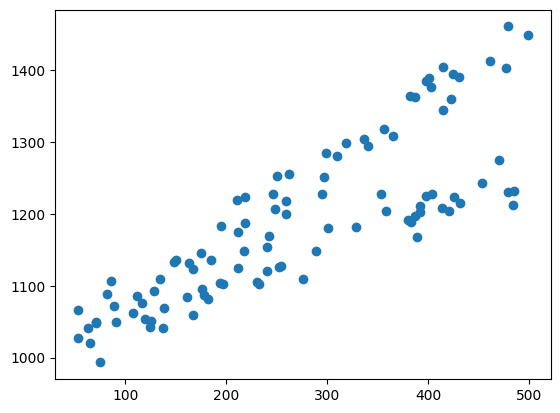

In [55]:
plt.scatter(data['ad_spend'], data['sales'])

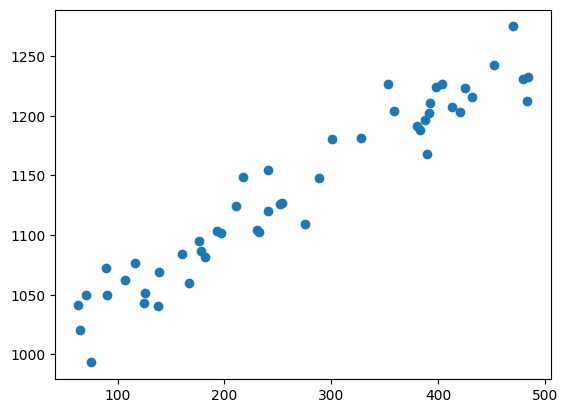

In [56]:
plt.scatter(data['ad_spend'][:50], data['sales'][:50])

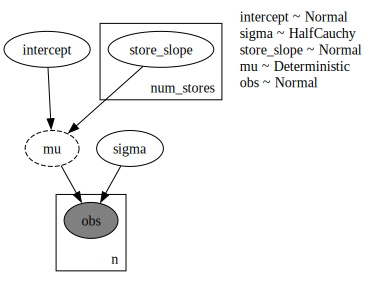

In [57]:
# partial pooled regression example
def partial_pooled_reg(x, store_indices, y=None):
    # Global intercept
    intercept = numpyro.sample("intercept", dist.Normal(1000, 10))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(1))
    # sigma = 1

    with numpyro.plate("num_stores", 2):
        slope = numpyro.sample("store_slope", dist.Normal(0, 1))
    
    mu = numpyro.deterministic("mu", intercept + slope[store_indices] * x)

    with numpyro.plate("n", len(y)):
        return numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)
    
numpyro.render_model(partial_pooled_reg, (data['ad_spend'], data['store_indices'], data['sales']), render_distributions=True)

In [63]:
kernel = NUTS(partial_pooled_reg)
mcmc = MCMC(kernel, num_warmup=200, num_samples=300, num_chains=4)
mcmc.run(random.PRNGKey(1), data['ad_spend'], data['store_indices'], data['sales'])

/var/folders/d5/nxx4jgmn0_5clxt1q54qmb740000gp/T/ipykernel_75550/596566369.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=200, num_samples=300, num_chains=4)
sample: 100%|██████████| 500/500 [00:00<00:00, 4965.59it/s, 31 steps of size 2.33e-02. acc. prob=0.93]


In [64]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
     intercept    994.71      4.46    994.53    987.09   1001.73    497.82      1.01
         sigma     20.77      1.48     20.68     18.29     23.02    368.32      1.01
store_slope[0]      0.53      0.02      0.53      0.50      0.56    538.07      1.01
store_slope[1]      0.91      0.02      0.91      0.88      0.94    603.47      1.01

Number of divergences: 0
